In [55]:
#importing dependencies
from PIL import Image
import sys
import os
import urllib
import tensorflow.contrib.tensorrt as trt
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np
import time
import cv2 as cv
import random
import string
from tf_trt_models.detection import download_detection_model, build_detection_graph
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/platf

In [7]:
# https://github.com/yeephycho/tensorflow-face-detection
FROZEN_GRAPH_NAME = 'data/frozen_inference_graph_face.pb'
!wget https://github.com/yeephycho/tensorflow-face-detection/blob/master/model/frozen_inference_graph_face.pb?raw=true -O {FROZEN_GRAPH_NAME}

--2019-10-16 03:37:40--  https://github.com/yeephycho/tensorflow-face-detection/blob/master/model/frozen_inference_graph_face.pb?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/yeephycho/tensorflow-face-detection/raw/master/model/frozen_inference_graph_face.pb [following]
--2019-10-16 03:37:40--  https://github.com/yeephycho/tensorflow-face-detection/raw/master/model/frozen_inference_graph_face.pb
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yeephycho/tensorflow-face-detection/master/model/frozen_inference_graph_face.pb [following]
--2019-10-16 03:37:40--  https://raw.githubusercontent.com/yeephycho/tensorflow-face-detection/master/model/frozen_inference_graph_face.pb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 

In [8]:
#Download an image with some faces
# go warriors!
IMAGE_PATH = 'data/warriors.jpg'
!wget 'https://cdn.vox-cdn.com/thumbor/rC0mlBATZdoDW1tEa44P6431sGc=/0x0:3683x2455/1200x800/filters:focal(1623x234:2211x822)/cdn.vox-cdn.com/uploads/chorus_image/image/63273148/usa_today_12005182.0.jpg' -O {IMAGE_PATH}

--2019-10-16 03:37:45--  https://cdn.vox-cdn.com/thumbor/rC0mlBATZdoDW1tEa44P6431sGc=/0x0:3683x2455/1200x800/filters:focal(1623x234:2211x822)/cdn.vox-cdn.com/uploads/chorus_image/image/63273148/usa_today_12005182.0.jpg
Resolving cdn.vox-cdn.com (cdn.vox-cdn.com)... 151.101.204.124
Connecting to cdn.vox-cdn.com (cdn.vox-cdn.com)|151.101.204.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116962 (114K) [image/jpeg]
Saving to: 'data/warriors.jpg'

data/warriors.jpg   100%[===================>] 114.22K   269KB/s    in 0.4s    

2019-10-16 03:37:46 (269 KB/s) - 'data/warriors.jpg' saved [116962/116962]



In [9]:
#Load the frozen graph
output_dir=''
frozen_graph = tf.GraphDef()
with open(os.path.join(output_dir, FROZEN_GRAPH_NAME), 'rb') as f:
  frozen_graph.ParseFromString(f.read())

In [10]:
#A few magical constants
INPUT_NAME='image_tensor'
BOXES_NAME='detection_boxes'
CLASSES_NAME='detection_classes'
SCORES_NAME='detection_scores'
MASKS_NAME='detection_masks'
NUM_DETECTIONS_NAME='num_detections'
input_names = [INPUT_NAME]
output_names = [BOXES_NAME, CLASSES_NAME, SCORES_NAME, NUM_DETECTIONS_NAME]

In [11]:
#Optimize the frozen graph using TensorRT
trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_names,
    max_batch_size=1,
    max_workspace_size_bytes=1 << 25,
    precision_mode='FP16',
    minimum_segment_size=50
)

In [12]:
#Create session and load graph
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_sess = tf.Session(config=tf_config)
# use this if you want to try on the optimized TensorRT graph
# Note that this will take a while
# tf.import_graph_def(trt_graph, name='')
# use this if you want to try directly on the frozen TF graph
# this is much faster
tf.import_graph_def(frozen_graph, name='')
tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_scores = tf_sess.graph.get_tensor_by_name('detection_scores:0')
tf_boxes = tf_sess.graph.get_tensor_by_name('detection_boxes:0')
tf_classes = tf_sess.graph.get_tensor_by_name('detection_classes:0')
tf_num_detections = tf_sess.graph.get_tensor_by_name('num_detections:0')


In [56]:
#def to generate random strings
def randomString(stringLength=10):
    """Generate a random string of fixed length """
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(stringLength))

In [85]:
#creating a def with the processing
def proce(image):
    plt.imshow(image)
    image_resized = np.array(image.resize((300, 300)))
    image = np.array(image)
    #Run network on Image
    scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
        tf_input: image_resized[None, ...]
    })
    boxes = boxes[0] # index by 0 to remove batch dimension
    scores = scores[0]
    classes = classes[0]
    num_detections = num_detections[0]
    #Display results
    # suppress boxes that are below the threshold.. 
    DETECTION_THRESHOLD = 0.5
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.imshow(image)

    # plot boxes exceeding score threshold
    for i in range(int(num_detections)):
        if scores[i] < DETECTION_THRESHOLD:
            continue
        # scale box to image coordinates
        box = boxes[i] * np.array([image.shape[0], image.shape[1], image.shape[0], image.shape[1]])

        # display rectangle
        patch = patches.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0], color='g', alpha=0.3)
        ax.add_patch(patch)

        # display class index and score
        plt.text(x=box[1] + 10, y=box[2] - 10, s='%d (%0.2f) ' % (classes[i], scores[i]), color='w')
        plt.savefig('data_fig/'+str(randomString())+'guery.jpg')
    
    #plt.show()
        

Average runtime: 2.900435 seconds
Average runtime: 0.357063 seconds
Average runtime: 0.358858 seconds
Average runtime: 0.354588 seconds
Average runtime: 0.347643 seconds
Average runtime: 0.350255 seconds
Average runtime: 0.346311 seconds
Average runtime: 0.348980 seconds
Average runtime: 0.357741 seconds
Average runtime: 0.348873 seconds
Average runtime: 0.353507 seconds
Average runtime: 0.357584 seconds
Average runtime: 0.373892 seconds
Average runtime: 0.371525 seconds
Average runtime: 0.370873 seconds
Average runtime: 0.419873 seconds
Average runtime: 0.376122 seconds
Average runtime: 0.365804 seconds


KeyboardInterrupt: 

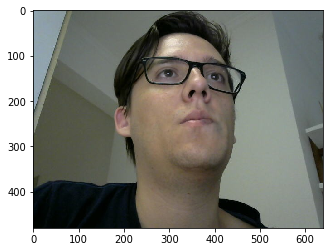

Error in callback <function flush_figures at 0x7f1202b598> (for post_execute):


KeyboardInterrupt: 

In [86]:
#capturing the frames via usb cam (using VideoCapture(1) to get the USB)
cap = cv.VideoCapture(1)
#working with the frames
while(True):
    t0 = time.time()
    ret,frame = cap.read()
    finm = 'tuts.jpg'
    cv.imwrite(finm,frame)
    image2 = Image.open(finm)
    proce(image2)
    t1 = time.time()
    print('Average runtime: %f seconds' % (float(t1 - t0)))
cap.release()

In [87]:
cap.release()

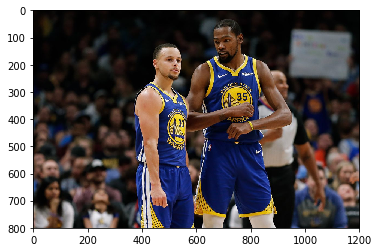

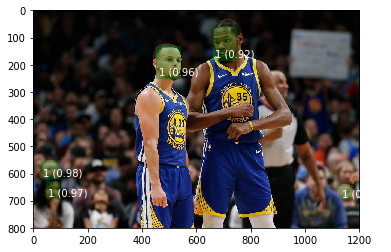

In [79]:
#Load and Preprocess Image
image = Image.open(IMAGE_PATH)
proce(image)

In [81]:
#benchmark
num_samples = 50

t0 = time.time()
for i in range(num_samples):
    scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
        tf_input: image_resized[None, ...]
    })
t1 = time.time()
print('Average runtime: %f seconds' % (float(t1 - t0) / num_samples))

In [ ]:
tf_sess.close()

In [ ]:
scores.mean()